# Anomaly Detection
### aka. How to Convince Your Boss that you need Machine Learning

---

Michal Grochmal <mike@grochmal.org>

## PyCon UK 2018



<div style="text-align:right;font-size:0.7em;">crown-scaled.svg</div>

## Table of Contents

- Marketing of Yours Truly
- General Intro to Anomaly Detection
  + Why Anomaly Detection
  + Is is Supervised or Unsupervised learning?
  + Regression-like, often on Time Series
- Explain the data
  + Webserver Logs
  + When we are not after time series
- Statistics of the Time Series
  + ARIMA
  + Is ARIMA worth it?
  + Other methods - including multidimensional ARIMA
- ML-like Stuff
  + Dimensionality
  + Baseline - density techniques
  + Isolation Forest
- Remember from this Talk
- References

### What do I do?

+ Teach Machine Learning at **City, University of London**
+ Do data munging at **Bank of America**

## Why Anomaly Detection?

- Easy to find data on which AD can be useful
- Easy to explain what it is doing (not too much Math)
- A good start for practical ML

## Is this AD thing Supervised or Unsupervised learning?

Well, both.
We normally classify ML techniques as either:

- Supervised - where we know the labels of the training data
- Unsupervised - where we have no labels

Most AD algorithms can either use labels
(whether each data point is an anomaly or not)
or use an estimate of how many anomalies exist in the data.
AD is classified instead into:

- Outlier Detection - where the data contains anomalies from which we can extrapolate
- Novelty Detection - where the training data has no anomalies

## Regression-like

Imagine that you want to use AD for some data in your company.
Most of the time this data will look more or less like a time series:

- Daily loading of data into a Data Warehouse - is it good data?
- Card transaction in a web shop by a user - is it fraud?
- Actions of a user in a web game - is this request viable?

But not always:

- New post on a forum - is it spam?

Yet, in pretty much all these cases AD works as a **regression**.
i.e. we perform a regression on the data we have - from previous days/occurences - predict
the value for today and compare that with what we actually got.

That is a little theoretical, let's try to do some AD in practice.

Where's the anomaly?



<div style="text-align:right;font-size:0.7em;">fly-anomaly.svg</div>

But if we make continuous steps, similar to a Time Series, the spider is not an anomaly anymore.



<div style="text-align:right;font-size:0.7em;">fly-norm.svg</div>

On the other hand, if both the spider and the fly are common, neither is an anomaly.



<div style="text-align:right;font-size:0.7em;">fly-spider-norm.svg</div>

We can bend this further.
If we have the fly "evolve" into a spider as before,
then a complete fly in the wrong position is an anomaly too.



<div style="text-align:right;font-size:0.7em;">fly-spider-anomaly.svg</div>

So what the hell is an **anomaly**?
Something **out of the common** where **common** is defined either by:

- In a set of things the common is area of features where these things lie
- In a series (e.g. time series) the common is a pattern that follows the series

But enough theory.
Let's import some Python scaffolding and play with actual data.

(Note: the "myxkcd" style is just my own matplotlib stylesheet
that works very similarly to `plt.xkcd()`.
A copy of the stylesheet is in the code repository for the talk.)

In [1]:
import json
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
plt.style.use('myxkcd')
XKCD_FONT = 'Humor Sans'



<div style="text-align:right;font-size:0.7em;">the-data.svg</div>

## Webserver Logs

We will use webserver logs to try to find anomalous requests to our webserver.
Webserver logs are:

- More or less a time series
- Very common in industry
- Most of us here have a least some *domain knowledge* on how HTTP works and what a webserver does

The assumption we will be working with is that anomalous connections to our
server may be either a working attack or reconnaissance in order to attack.
And we may want to have a closer look at such connections.

We can load the logs with some Python into a Pandas Data Frame.

In [2]:
with open('access.log', encoding='latin-1') as f:
    df = pd.DataFrame(json.loads(l) for l in f)
with open('access.labels') as f:
    df['label'] = pd.Series(int(l) for l in f)
df.head()

,bytes_sent,content_length,content_type,cookie_csrftoken,cookie_sessionid,cookie_userid,geoip_city,geoip_country_code3,geoip_country_name,geoip_latitude,...,ssl_cipher,ssl_curves,ssl_protocol,ssl_session_reused,status,time_iso8601,upstream_cache_status,upstream_response_time,upstream_status,label
0,486,,,,,,,USA,United States,13.7500,...,ECDHE-RSA-AES128-GCM-SHA256,0x001d:prime256v1:secp384r1,TLSv1.2,.,301,2018-05-11T03:33:26+00:00,,,,1
1,2999,,,,,,Saint Petersburg,RUS,Russian Federation,59.8944,...,,,,,200,2018-05-11T03:34:33+00:00,MISS,0.000,200,1
2,481,,,,,,,USA,United States,13.7500,...,ECDHE-RSA-AES128-GCM-SHA256,0x001d:prime256v1:secp384r1,TLSv1.2,.,301,2018-05-11T03:51:23+00:00,,,,1
3,449,,,,,,Edison,USA,United States,40.4981,...,,,,,301,2018-05-11T04:02:52+00:00,,,,1
4,792,,,,,,Saint Petersburg,RUS,Russian Federation,59.8944,...,,,,,200,2018-05-11T05:09:04+00:00,,,,1


The `access.log` file contains request logs from an NGINX webserver running on a **honeypot**.
I did configure the NGINX to output logs in JSON format,
i.e. each line is a full request to the server in a JSON representation.

We have some 10k request collected over a little more than a month.
The number of "strange" requests is quite high, this is because the is a honeypot.
There are almost 10% anomalous connections in the data,
the file `access.labels` contains the labels of the data generated through another AD system.

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10789 entries, 0 to 10788
Data columns (total 39 columns):
bytes_sent                10789 non-null int64
content_length            10789 non-null object
content_type              10789 non-null object
cookie_csrftoken          10789 non-null object
cookie_sessionid          10789 non-null object
cookie_userid             10789 non-null object
geoip_city                10789 non-null object
geoip_country_code3       10789 non-null object
geoip_country_name        10789 non-null object
geoip_latitude            10789 non-null object
geoip_longitude           10789 non-null object
geoip_region_name         10789 non-null object
gzip_ratio                10789 non-null object
host                      10789 non-null object
http2                     10789 non-null object
http_referer              10789 non-null object
http_user_agent           10789 non-null object
http_x_csrf_token         10789 non-null object
http_x_forwarded_for      10

The data's there but this isn't good data for Machine Learning,
we mostly have strings (`object` in the data frame).
Moreover, there is a lot of repetition and probably a lot of missing data.
For the repetition we will need to use our domain knowledge,
for the missing data we can count the unique values in each column.

In [4]:
for i in df.columns:
    print(i, len(df[i].unique()))

bytes_sent 379
content_length 21
content_type 16
cookie_csrftoken 1
cookie_sessionid 1
cookie_userid 2
geoip_city 609
geoip_country_code3 84
geoip_country_name 84
geoip_latitude 772
geoip_longitude 777
geoip_region_name 373
gzip_ratio 37
host 42
http2 2
http_referer 141
http_user_agent 282
http_x_csrf_token 1
http_x_forwarded_for 7
remote_addr 2444
remote_port 6806
request 472
request_id 10789
request_length 479
request_method 6
request_time 67
request_uri 384
scheme 2
server_protocol 4
ssl_cipher 8
ssl_curves 22
ssl_protocol 4
ssl_session_reused 3
status 12
time_iso8601 7630
upstream_cache_status 4
upstream_response_time 31
upstream_status 6
label 2


Where we see the value 1, we have all values the same in this column across our dataset.
Such a column will not help us identifying anything.
And where we see values in the thousands we probably have too many values to make sense of them.
The exception is `time_iso8601`, the time of the request, because it is an always increasing value.

We can drop what will not help us.

In [5]:
df = df.drop([
    'content_length',         # only present in POST, duplicate of request_method: POST
    'cookie_csrftoken',       # no variance
    'cookie_sessionid',       # no variance
    'geoip_city',             # use geoip_country_name
    'geoip_country_code3',    # use geoip_country_name
    'geoip_latitude',         # use geoip_country_name
    'geoip_latitude',         # use geoip_country_name
    'geoip_longitude',        # use geoip_country_name
    'geoip_region_name',      # use geoip_country_name
    'http_x_csrf_token',      # no variance
    'remote_addr',            # too much variance
    'remote_port',            # this is actually random
    'request_id',             # unique ID
    'ssl_curves',             # use ssl_cipher
    'ssl_protocol',           # use ssl_cipher,
    'upstream_cache_status',  # use upstream_response_time
    'upstream_status',        # use upstream_response_time
], axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10789 entries, 0 to 10788
Data columns (total 23 columns):
bytes_sent                10789 non-null int64
content_type              10789 non-null object
cookie_userid             10789 non-null object
geoip_country_name        10789 non-null object
gzip_ratio                10789 non-null object
host                      10789 non-null object
http2                     10789 non-null object
http_referer              10789 non-null object
http_user_agent           10789 non-null object
http_x_forwarded_for      10789 non-null object
request                   10789 non-null object
request_length            10789 non-null int64
request_method            10789 non-null object
request_time              10789 non-null float64
request_uri               10789 non-null object
scheme                    10789 non-null object
server_protocol           10789 non-null object
ssl_cipher                10789 non-null object
ssl_session_reused        10

### Feature Extraction

Now we will need to perform some feature extraction.
From the strings we have to build numerical features that can then be fed to an algorithm.
The column that is most likely to produce good insight into the request is `request`,
it contains the string that the client did send after estabilishing the connection, e.g.

    GET /home.php HTTP/1.1

But attacks may attempt to exploit a known vulnerability in a webserver and send
a binary payload instead of such a string.
Binary payloads will often contain bytes outside of typical character range (e.g. ASCII)
therefore we will find the highest and lowest byte value inside the request string
as two viable features to use.

In [6]:
request_functions = {min: 0xff, max: 0}
column = 'request'
for f in request_functions:
    df[column + '_' + f.__name__] = pd.Series(
        f([ord(c) for c in row] + [request_functions[f]]) for row in df[column])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10789 entries, 0 to 10788
Data columns (total 25 columns):
bytes_sent                10789 non-null int64
content_type              10789 non-null object
cookie_userid             10789 non-null object
geoip_country_name        10789 non-null object
gzip_ratio                10789 non-null object
host                      10789 non-null object
http2                     10789 non-null object
http_referer              10789 non-null object
http_user_agent           10789 non-null object
http_x_forwarded_for      10789 non-null object
request                   10789 non-null object
request_length            10789 non-null int64
request_method            10789 non-null object
request_time              10789 non-null float64
request_uri               10789 non-null object
scheme                    10789 non-null object
server_protocol           10789 non-null object
ssl_cipher                10789 non-null object
ssl_session_reused        10

We still have a lot of columns to go.
For the remaining columns that we are rather confident are strings
we will simply take the length of the strings as a feature.

If our AD system performs poorly we will need to come back and find
better features but for now this will suffice.

In [7]:
len_columns = [
    'content_type',
    'host',
    'http_referer',
    'http_user_agent',
    'http_x_forwarded_for',
    'cookie_userid',
    'request',  # here again, we may as well take the length too
    'request_uri',
]
for c in len_columns:
    df[c] = df[c].str.len()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10789 entries, 0 to 10788
Data columns (total 25 columns):
bytes_sent                10789 non-null int64
content_type              10789 non-null int64
cookie_userid             10789 non-null int64
geoip_country_name        10789 non-null object
gzip_ratio                10789 non-null object
host                      10789 non-null int64
http2                     10789 non-null object
http_referer              10789 non-null int64
http_user_agent           10789 non-null int64
http_x_forwarded_for      10789 non-null int64
request                   10789 non-null int64
request_length            10789 non-null int64
request_method            10789 non-null object
request_time              10789 non-null float64
request_uri               10789 non-null int64
scheme                    10789 non-null object
server_protocol           10789 non-null object
ssl_cipher                10789 non-null object
ssl_session_reused        10789 non-

Some features represent floating point numbers.
i.e. the strings are actually numbers.
We can simply parse these numbers and use as features.

In [8]:
numbers = [
    'gzip_ratio',
    'upstream_response_time',
]
for c in numbers:
    df.loc[df[c] == '', c] = 0  # prevent NaNs
    df[c] = pd.to_numeric(df[c])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10789 entries, 0 to 10788
Data columns (total 25 columns):
bytes_sent                10789 non-null int64
content_type              10789 non-null int64
cookie_userid             10789 non-null int64
geoip_country_name        10789 non-null object
gzip_ratio                10789 non-null float64
host                      10789 non-null int64
http2                     10789 non-null object
http_referer              10789 non-null int64
http_user_agent           10789 non-null int64
http_x_forwarded_for      10789 non-null int64
request                   10789 non-null int64
request_length            10789 non-null int64
request_method            10789 non-null object
request_time              10789 non-null float64
request_uri               10789 non-null int64
scheme                    10789 non-null object
server_protocol           10789 non-null object
ssl_cipher                10789 non-null object
ssl_session_reused        10789 non

Other columns are inherently categorical, e.g.

- http2 is either true or false
- request_mathod must be a valid method such as GET, POST, PUT, HEAD
- ssl_cipher also has a limited number of allowed cyphers

We use one-hot-encoding (dummies) for the categorical values.

In [9]:
dummies = [
    'geoip_country_name',
    'http2',
    'request_method',
    'scheme',
    'server_protocol',
    'ssl_cipher',
    'ssl_session_reused',
    'status',
]
df = pd.get_dummies(df, columns=dummies)
df.columns

Index(['bytes_sent', 'content_type', 'cookie_userid', 'gzip_ratio', 'host',
       'http_referer', 'http_user_agent', 'http_x_forwarded_for', 'request',
       'request_length',
       ...
       'status_302', 'status_304', 'status_400', 'status_403', 'status_404',
       'status_408', 'status_418', 'status_429', 'status_500', 'status_502'],
      dtype='object', length=138)

Finally we can parse the time column into a time data structure.

In [10]:
column = 'time_iso8601'
df[column] = pd.to_datetime(df[column])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10789 entries, 0 to 10788
Columns: 138 entries, bytes_sent to status_502
dtypes: datetime64[ns](1), float64(3), int64(13), uint8(121)
memory usage: 2.6 MB


## When we are not after a Time Series

The webserver logs are more-or-less a time series.
They can be treated as a time series but they can be treated as not a series as well.
The time as a form of ordering the data is useful often but,
if we want to understand how the data may vary within a period,
we may extract less granular information of the time of the requests.

Here we will take the hour at which the request happened.
This will allow us to see whether traffic varies depending on the time of the day.

In [11]:
df['time_of_day'] = df['time_iso8601'].dt.hour
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10789 entries, 0 to 10788
Columns: 139 entries, bytes_sent to time_of_day
dtypes: datetime64[ns](1), float64(3), int64(14), uint8(121)
memory usage: 2.7 MB


We now have lots of columns again.
Let's a have a look at how the table looks.

In [12]:
df.head()

,bytes_sent,content_type,cookie_userid,gzip_ratio,host,http_referer,http_user_agent,http_x_forwarded_for,request,request_length,...,status_304,status_400,status_403,status_404,status_408,status_418,status_429,status_500,status_502,time_of_day
0,486,0,0,0.0,12,0,71,0,19,272,...,0,0,0,0,0,0,0,0,0,3
1,2999,0,0,2.6,16,0,64,0,52,258,...,0,0,0,0,0,0,0,0,0,3
2,481,0,0,0.0,12,0,71,0,14,267,...,0,0,0,0,0,0,0,0,0,3
3,449,0,0,0.0,1,0,59,0,14,104,...,0,0,0,0,0,0,0,0,0,4
4,792,0,0,0.0,16,0,64,0,24,199,...,0,0,0,0,0,0,0,0,0,5


Too many columns for `df.head`
but we can at least look whether the one-hot-encoding looks correct.

In [13]:
df[['status_200', 'status_301', 'status_302', 'status_304',
    'status_400', 'status_403', 'status_404', 'status_500',
    'gzip_ratio', 'time_of_day', 'time_iso8601', 'label']].head(10)

,status_200,status_301,status_302,status_304,status_400,status_403,status_404,status_500,gzip_ratio,time_of_day,time_iso8601,label
0,0,1,0,0,0,0,0,0,0.00,3,2018-05-11 03:33:26,1
1,1,0,0,0,0,0,0,0,2.60,3,2018-05-11 03:34:33,1
2,0,1,0,0,0,0,0,0,0.00,3,2018-05-11 03:51:23,1
3,0,1,0,0,0,0,0,0,0.00,4,2018-05-11 04:02:52,1
4,1,0,0,0,0,0,0,0,0.00,5,2018-05-11 05:09:04,1
5,1,0,0,0,0,0,0,0,2.52,5,2018-05-11 05:09:08,1
6,0,0,0,0,1,0,0,0,0.00,5,2018-05-11 05:20:51,-1
7,1,0,0,0,0,0,0,0,3.43,5,2018-05-11 05:41:14,1
8,1,0,0,0,0,0,0,0,1.64,5,2018-05-11 05:51:06,1
9,1,0,0,0,0,0,0,0,2.08,5,2018-05-11 05:51:08,1


We made features out of almost all columns we had.
Since several of these features are numerical we can have a look at their histograms
to see the distribution of our data in those dimensions.

The histograms can even tell us where we expect anomalies.
Note that we will use a logarithmic scale.
When searching for something uncommon, e.g. anomaly,
a logarithmic scale is more likely to give us a god graph.

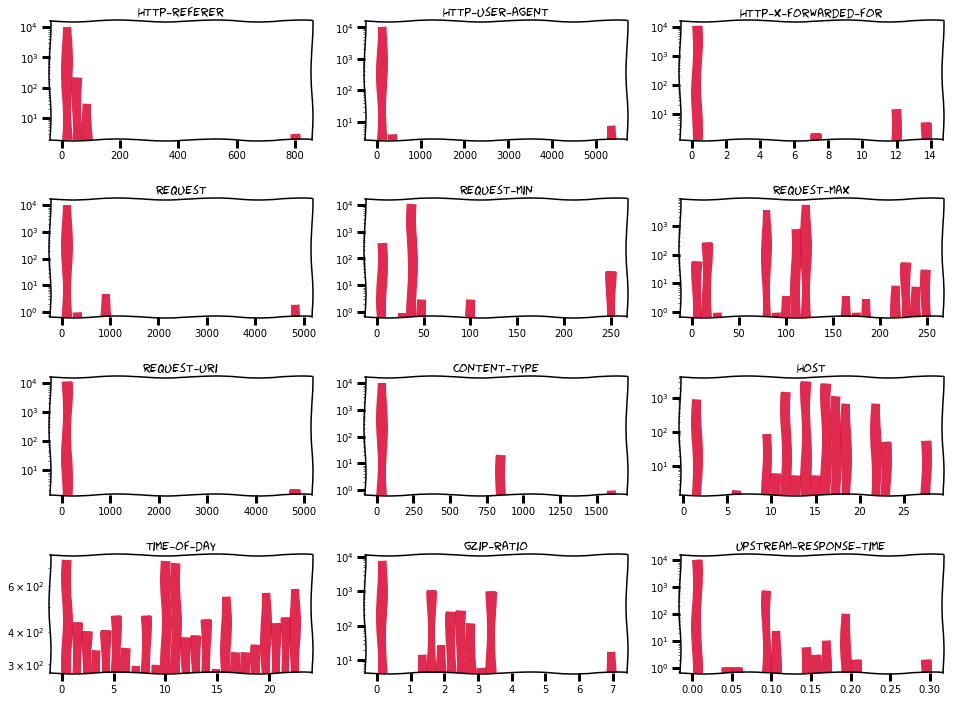

In [14]:
fig, axi = plt.subplots(4, 3, figsize=(16, 12))
columns = [
    'http_referer',
    'http_user_agent',
    'http_x_forwarded_for',
    'request',
    'request_min',
    'request_max',
    'request_uri',
    'content_type',
    'host',
    'time_of_day',
    'gzip_ratio',
    'upstream_response_time',
]
for i in range(len(columns)):
    ax = axi.flat[i]
    ax.hist(df[columns[i]], log=True, bins=24,
            histtype='bar', facecolor='crimson', alpha=0.9)
    ax.set_title(columns[i], fontname=XKCD_FONT)
fig.subplots_adjust(wspace=0.2, hspace=0.5)



<div style="text-align:right;font-size:0.7em;">time-series.svg</div>

We did talk a lot about Time Series but what the hell is a time series in the first place?
A time series is anything piece of data that can be ordered in time,
and where we assume that a moving trend will happen reasonably slowly.

Since we do have a time column in our data we can plot is as a time series.
Moreover, since we do have the labels of the data we can try to see
the relationship of the anomalies across the time.
We will use the column which has the biggest variance above: `request`.

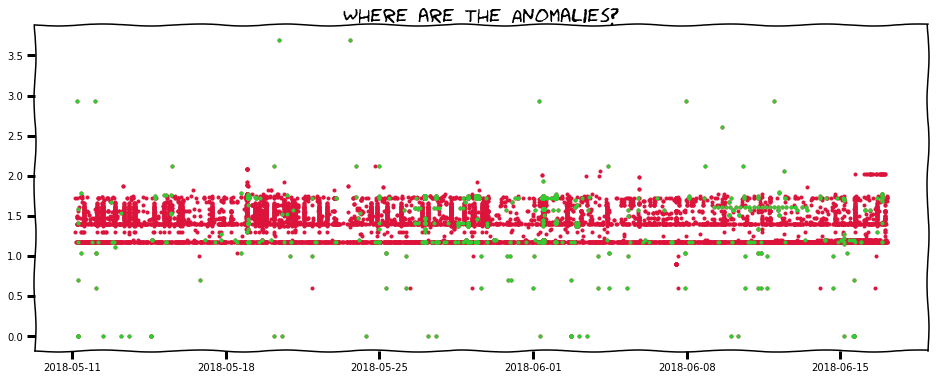

In [15]:
fig, ax = plt.subplots(figsize=(16, 6))
ano = df.label == -1
ax.plot(df.time_iso8601, np.log10(df.request + 1), '.', color='crimson')
ax.plot(df.time_iso8601[ano], np.log10(df.request[ano] + 1), '.', color='limegreen')
ax.set_title('Where are the Anomalies?', fontname=XKCD_FONT, size=20);

We can see that we can find some of the anomalies using the `request` column alone.
There exist a central area in which normal data points live,
and everything away from that area are definitely anomalies.
There exist anomalies within the central area but we are unlikely to be able to
catch these using the time and request length alone.

The first problem we need o tackle is the fact that the central area is quite wide,
and trying to define how wide it is "by the eye" is quite arbitrary.
Instead we can *derivate* the time series and produce a clean central area.

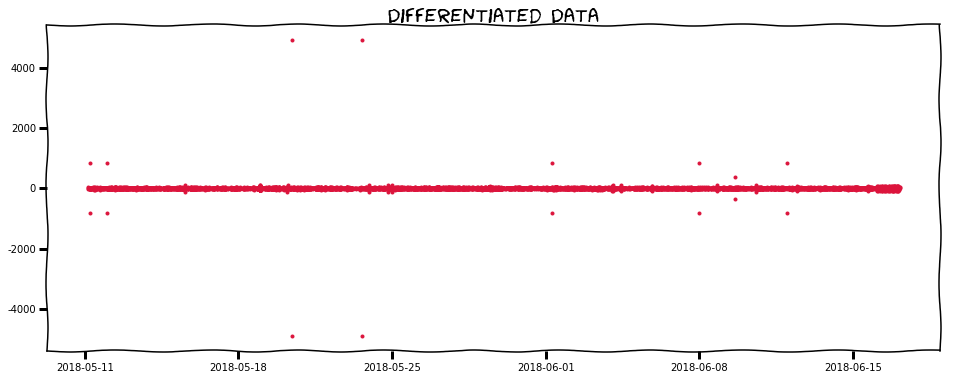

In [16]:
fig, ax = plt.subplots(figsize=(16, 6))
diff = df.request[:-1].values - df.request[1:].values
ax.plot(df.time_iso8601[1:], diff, '.', color='crimson')
ax.set_title('Differentiated Data', fontname=XKCD_FONT, size=20);

Derivating discrete data is a trivial task, it simply is every point minus the previous one.
Nevertheless we can now see the anomalies we want to catch clearly.

## Enters ARIMA

Auto-Regressive Integrated Moving Average (ARIMA), or
Seasonal Auto-Regressive Integrated Average eXtended (SARIMAX),
or any other combination thereof.
Mathematically ARIMA is more or less:

$$
\hat{y}_n = \theta_1 (y_{n - 1} - y_{n - 2}) + \theta_0
$$

There are several different ways of adding other terms to that equation
but this format is enough for us.
We can say that the AR term in ARIMA is just a random walk
where the next step will be close to the size of the recent steps.

Let's try this ARIMA thing out.
In `statsmodels` the SARIMAX model is much faster,
and can be used without the seasonal part.

In [17]:
import statsmodels.api as sm

y = df.request
ar, diffi, ma = 3, 1, 0
sarimax = sm.tsa.statespace.SARIMAX(y, order=(ar, diffi, ma))
results = sarimax.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                request   No. Observations:                10789
Model:               SARIMAX(3, 1, 0)   Log Likelihood              -62409.417
Date:                Mon, 10 Sep 2018   AIC                         124826.834
Time:                        13:15:28   BIC                         124855.978
Sample:                             0   HQIC                        124836.662
                              - 10789                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7461      0.001  -1208.498      0.000      -0.747      -0.745
ar.L2         -0.4963      0.001   -687.268      0.000      -0.498      -0.495
ar.L3         -0.2489      0.001   -396.117      0.000      -0.250      -0.248
sigma2      6201.0363      2.237   2772.415      0.000    6196.652    6205.420
===================================================================================
Ljung-Box (Q):                      815.57   Jarque-Bera (JB):        3653070587.98
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.08   Skew:                            42.60
Prob(H) (two-sided):                  0.00   Kurtosis:                      2852.51
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

We expect that we modeled the middle region of our data,
and then anything that is not in that middle region will be an anomaly.
In other words, the model should predict a value within the middle region for every data point,
when we compare the prediction against the real point a big difference means an anomaly.

Below we plot the data in *red* and the model predictions in *blue*.

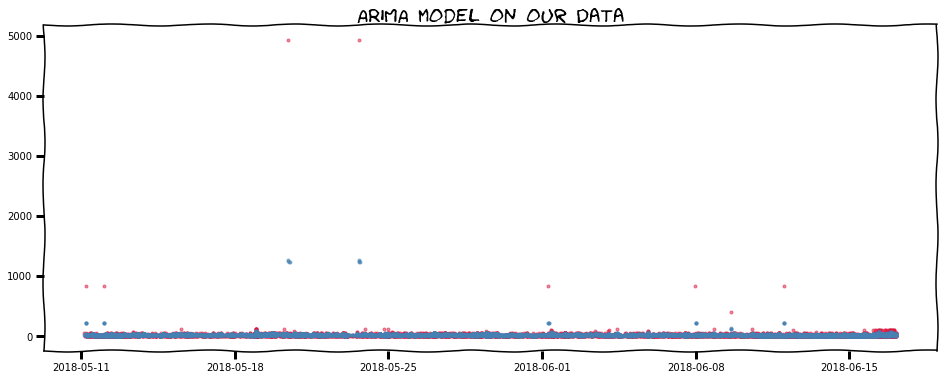

In [18]:
pred_y = results.predict(start=diffi, end=len(y)-diffi)
fig, ax = plt.subplots(figsize=(16, 6))
ax.plot(df.time_iso8601[diffi:], df.request[diffi:], '.', color='crimson', alpha=0.5)
ax.plot(df.time_iso8601[diffi:], pred_y, '.', color='steelblue', alpha=0.5)
ax.set_title('ARIMA model on our Data', fontname=XKCD_FONT, size=20);

That does not appear to be quite right.
The predictions right after each anomaly are skewed towards the anomaly!
This is because ARIMA is a **novelty detection** model,
if we train a novelty detection models with data containing anomalies
we will always get a bad model.

Let's remove the anomalies from our data and try again.

In [19]:
y = pd.Series(df.request[df.request < 200].values)
ar, diffi, ma = 3, 1, 0
sarimax = sm.tsa.statespace.SARIMAX(y, order=(ar, diffi, ma))
results = sarimax.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                10781
Model:               SARIMAX(3, 1, 0)   Log Likelihood              -43424.135
Date:                Mon, 10 Sep 2018   AIC                          86856.271
Time:                        13:15:42   BIC                          86885.413
Sample:                             0   HQIC                         86866.098
                              - 10781                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6142      0.006   -109.616      0.000      -0.625      -0.603
ar.L2         -0.3923      0.007    -52.335      0.000      -0.407      -0.378
ar.L3         -0.2313      0.006    -35.626      0.000      -0.244      -0.219
sigma2       184.5791      1.149    160.633      0.000     182.327     186.831
===================================================================================
Ljung-Box (Q):                      696.98   Jarque-Bera (JB):             29672.27
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.21   Skew:                             1.02
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.87
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In the new plot we see what we expected of the model.
The model predictions are all within a small area where we see reasonable lengths
for the request strings.

Too long strings are far apart from the model,
and when comparing prediction to received value we can tell anomalies apart.

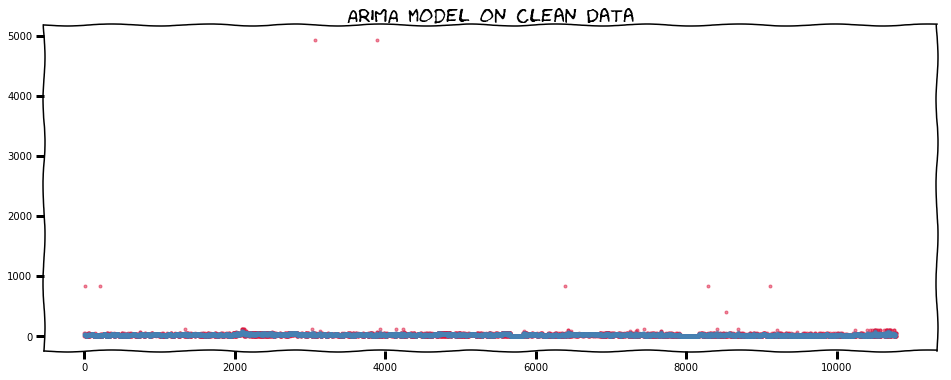

In [20]:
pred_y = results.predict(start=diffi, end=len(y)-diffi)
fig, ax = plt.subplots(figsize=(16, 6))
ax.plot(range(len(df.request)-diffi), df.request[diffi:], '.', color='crimson', alpha=0.5)
ax.plot(range(len(y)-diffi), pred_y, '.', color='steelblue', alpha=0.5)
ax.set_title('ARIMA model on Clean Data', fontname=XKCD_FONT, size=20);

## Is ARIMA worth it?

As in, that looks like a model that simply compares to the mean.
In part that's true.
One needs to remember that the main objective of statistical models is to explain the data,
not to predict new data or perform AD.
For almost all cases of using ARIMA for AD a model such as:

$$
\hat{y}_n = \texttt{mean}(y_{n-1}, y_{n-2}, y_{n-3})
$$

Is enough, and then checking for anomalies with:

$$
\| \hat{y}_n - y_n \| > \texttt{std}(y_{n-1}, y_{n-2}, y_{n-3})
$$

Seasonality, as in SARIMA, may not be covered by such a simple model.
Yet, with SARIMA, one needs to define the seasonality by hand,
and one could do the same with the mean and standard deviation model.

In summary, if you feel well about ARIMA, use it.
If you find that simplifying it to a trivial model that check against the mean
works well for your data, then there's nothing wrong with that.

### Multidimensional ARIMA

We are only catching a small subset of the anomalies with the model we have.
This is because we are using only information about the length of the request string.

One can add extra regressors to an ARIMA model but these can get out of hand quickly.
Much simpler, and most commonly used are several ARIMA models, one for each dimension.
In other words, we could build an ARIMA model for each of the columns we have.
Then we would combine the results and consider anomalies by vote.

Yet, with highly dimensional data,
it is better to use a model that expects multidimensional data.



<div style="text-align:right;font-size:0.7em;">machine-learning.svg</div>

OK, now for the part we all are here for.

Several techniques exist to find anomalies in data that does not neatly fit
a 2-dimensional time series.
Yet, the time of the even (request) may still play an important role.
Since we are looking at webserver logs I expect to have some form of seasonality
around the time of the day an request happened.
For example, websites specific to a certain country will have different traffic
during the day and different traffic over night.
We did the trick of adding a column named `time_of_day` with the hour of the request,
the granularity of hours should be good enough for us.

## Dimensionality

We will work with our data in vectorial space,
i.e. space where each point is a vector in the number of dimensions
defined by the number of features we have.
On dimension per column in our data frame.
As with most ML algorithms,
the techniques we are going to use are sensitive to the scale of the input values.
Therefore we are going to scale all numerical columns to have mean zero
and standard deviation one.

In [21]:
from sklearn.preprocessing import StandardScaler

scaled_columns = [
    'bytes_sent',
    'content_type',
    'gzip_ratio',
    'host',
    'http_referer',
    'http_user_agent',
    'http_x_forwarded_for',
    'request',
    'request_length',
    'request_time',
    'request_uri',
    'upstream_response_time',
    'request_min',
    'request_max',
    'time_of_day',
]
scaler = StandardScaler(copy=True)
mldf = pd.DataFrame(scaler.fit_transform(df[scaled_columns]), columns=scaled_columns)
cat_cols = [x for x in df.columns if x not in scaled_columns + ['time_iso8601', 'label']]
mldf[cat_cols] = df[cat_cols]
mldf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10789 entries, 0 to 10788
Columns: 137 entries, bytes_sent to status_502
dtypes: float64(15), int64(1), uint8(121)
memory usage: 2.6 MB


Note that we did not scale the categorical features,
which are in one-hot-encoding format.

Another things we should do is to figure out what ratio of anomalies we have,
this will allow us two things:

- Some Novelty Detection ML algorithms can work with anomalies in the training data,
  as long as they either know which are the anomalies or how many anomalies to expect.

- The ratio can tell the accuracy of a dummy algorithms,
  i.e. an algorithm that never ever hails an anomaly.
  If anything we train is worse than that, we can throw it away.

We also place the data in variables `X` and `y` commonly used in ML.

In [22]:
X, y = mldf.values, df.label

incidents = np.sum(df.label == -1)
incident_factor = incidents / len(mldf)
incident_factor

0.08999907313003985

I need to say that I did cheat a little in the preparation of this data.
The real ratio in the 30k is about 3%, sensible for webserver anomalies.
Yet, most AD algorithms work best with a ratio close to 10%,
therefore 2/3 of the data was dropped at random.
AD will always have a disproportionate number of samples for each class (support),
therefore algorithms used for AD are reasonable to work with that.

## Baseline

For a start let's try to build a baseline:
use a very simple technique and only then try to improve on it's results.
The *Local Outlier Factor* is a density technique, it is similar in spirit to kNN.
The LOF counts the distances to the closest neighbors of each point.
The points with its neighbors close should be normal points,
whilst the points with its neighbors far away should be anomalies.

In [23]:
from sklearn.neighbors import LocalOutlierFactor

lof = LocalOutlierFactor(n_neighbors=30, contamination=incident_factor)
y_hat = lof.fit_predict(X, y)
np.unique(y_hat)

array([-1,  1])

The common way of labeling in AD is:

- 1 is a normal data point
- -1 is an anomaly

We checked that our algorithm does output both,
i.e. that it did not attempt the trivial solution of labeling all points as normal.
We shall also use a robust measure to check it's working.
The F1 score will heavily penalize models that have poor precision or recall,
therefore it is a reasonable measure for disproportionate support.

In [24]:
from sklearn.metrics import f1_score

f1_score(y, y_hat)

0.9186188633122836

That is reasonable.
Note that this is not to be compared against $1 - \texttt{incident ratio}$,
since the F1 score uses a harmonic measure between precision and recall.

Note that LOF can be used without prior knowledge of the labels.
Let's assume that we do not have the labels and we estimate the number of anomalies
(the incident factor) to be 10%, instead of 8.9%.
LOF performs worse but still quite reasonably without the knowledge of the labels.

In [25]:
lof = LocalOutlierFactor(n_neighbors=30, contamination=0.1)
y_hat = lof.fit_predict(X)
f1_score(y, y_hat)

0.9131414524224112

## Isolation Forest

Now that we have a baseline we can try more complex techniques.
The *Isolation Forest* performs splits of the feature space
in a similar fashion to a Random Forest.
The difference is that the Isolation Forest splits
until it reaches leaf sizes of 1 (single data point).
Anomalies should need very few splits to be split from the rest of the data.
Whilst normal points should require many splits.

In [26]:
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
iso = IsolationForest(n_estimators=200, contamination=incident_factor)
iso.fit(X_train, y_train)
y_hat = iso.predict(X_test)
f1_score(y_test, y_hat)

0.9926563687009369

The F1 score is quite good but it does not tell us where the algorithm is making the mistakes.
Instead we can, and should, look at the confusion matrix of the classification.

In the confusion matrix we see false positives and false negatives.
We can tune to have less false positives at the cost of having more false positives, and vice-versa.
We can perform that by assigning different class weights to anomalies (-1) and normal (1) points.

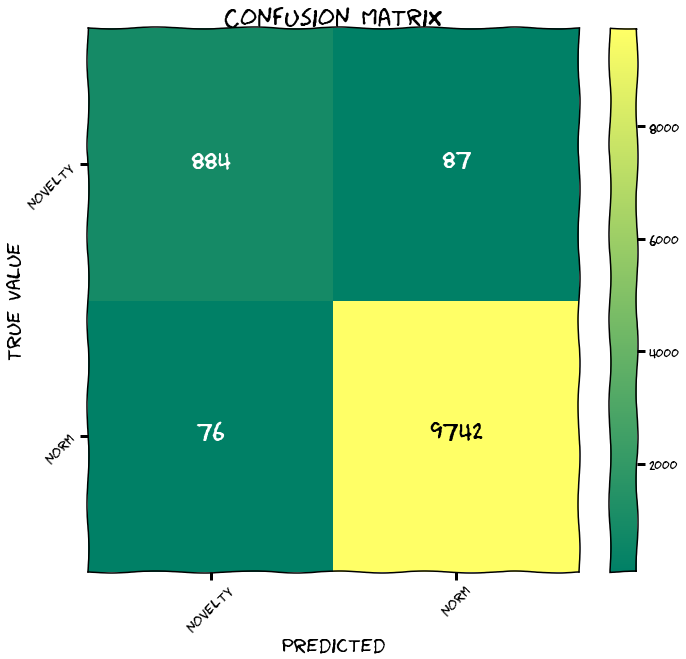

In [27]:
import itertools
from sklearn.metrics import confusion_matrix

y_hat = iso.predict(X)
cm = confusion_matrix(y, y_hat)[::-1, :]
ticks = ['novelty', 'norm']

fig, ax = plt.subplots(figsize=(11, 10))
mesh = ax.pcolormesh(cm, cmap='summer')
cb = fig.colorbar(mesh)
cb.ax.set_yticklabels(cb.ax.get_yticklabels(), fontname=XKCD_FONT, size=14)
threshold = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    ax.text(j+0.5, i+0.5, cm[i, j], horizontalalignment='center',
            color='k' if cm[i, j] > threshold else 'w', fontname=XKCD_FONT, size=24)
ax.set_title('Confusion Matrix', fontname=XKCD_FONT, size=24)
ax.set_xlabel('Predicted', fontname=XKCD_FONT, size=20)
ax.set_ylabel('True Value', fontname=XKCD_FONT, size=20)
ax.set_xticks([0.5, 1.5])
ax.set_yticks([0.5, 1.5])
ax.set_xticklabels(ticks, rotation=45, fontname=XKCD_FONT, size=14)
ax.set_yticklabels(ticks[::-1], rotation=45, fontname=XKCD_FONT, size=14);

Another technique similar in working but very different
in spirit to the Isolation Forest is the *One Class SVM*.
The One Class SVM defines the most outer normal points as support vectors,
and then all points that are outside the "normal" area are considered anomalies.

## Remember from this Talk

- Novelty Detection vs Outlier Detection
- Feature Extraction
- Explainability/Tunability of the methods

AD may appear as a rather specific field to a typical programmer but that's far from true.
AD is just a clever (read: slightly different) way of using well known ML techniques.

## References

- [SciKit-Learn - Novelty and Outlier Detection][1]
- [Statsmodels - ARIMA and SARIMAX examples][2]
- [ARIMA models - Robert Nau][3]
- [Information Retrieval - Precision and Recall][4]
- [NGINX logging formats][5]
- [XKCD style and fonts][6]
- [City ML short course - shameless marketing][7]

[1]: http://scikit-learn.org/stable/modules/outlier_detection.html
[2]: https://www.statsmodels.org/dev/examples/notebooks/generated/statespace_sarimax_stata.html
[3]: https://people.duke.edu/~rnau/411arim.htm
[4]: https://nlp.stanford.edu/IR-book/html/htmledition/evaluation-of-unranked-retrieval-sets-1.html
[5]: http://nginx.org/en/docs/http/ngx_http_log_module.html
[6]: https://xkcd.com/
[7]: https://www.city.ac.uk/courses/short-courses/introduction-to-data-analysis-and-machine-learning-with-python